## Clustering

In [ ]:
!pip install --q skimage

In [43]:
import torch
from skimage.measure import label

matrix = torch.tensor([
    [1, 0, 0, 1],
    [0, 0, 1, 1],
    [1, 1, 0, 0],
    [0, 0, 0, 1]
], dtype=torch.int)

In [44]:
matrix = 1 - matrix

In [45]:
lmatrix, nc = label(matrix.numpy(), connectivity=2, return_num=True)

c_sizes = torch.bincount(torch.tensor(lmatrix.flatten()))
c_sizes = c_sizes[1:]  # Exclude background label (0)
nc = len(c_sizes)
nc, c_sizes

(1, tensor([9]))

## Loading the model

In [19]:
from fastai.vision.all import *

In [16]:
models_path = Path.cwd() / "models"

In [20]:
def label_func(path):
    fname = path.name
    img_id = str(fname.split("_sat")[0])
    return path.parent / (img_id + "_mask_pre_binary.png")

In [21]:
binary_unet = load_learner(models_path / "binary_unet_convnext_focal_256px_10e_bs8_gac_aug.pkl")

## Creating a function to easily get the predictions for a file

In [22]:
from dataclasses import dataclass

@dataclass
class BinarySegmentationPrediction:
    mask: torch.Tensor
    probabilities: torch.Tensor


def binary_segmentation(path):
    _, pred, pred_proba = binary_unet.predict(path)
    return BinarySegmentationPrediction(
        pred,
        pred_proba[1]
    )

In [26]:
prediction = binary_segmentation(
    Path.cwd() / "segmentation_preprocessed" / "test" / "668404_sat.jpg"
)

/Users/smorrin/anaconda3/lib/python3.11/site-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/Users/smorrin/anaconda3/lib/python3.11/site-packages/fastai/metrics.py:390: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


## Showing the prediction

In [32]:
from torchvision.transforms.functional import to_pil_image

def show_prediction(prediction: BinarySegmentationPrediction):
    return to_pil_image(prediction.mask.float())

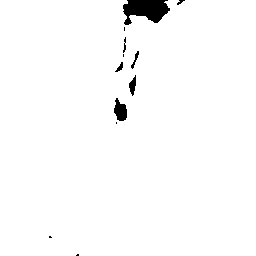

In [34]:
show_prediction(prediction)

## Doing the clustering

In [39]:
pred_matrix = prediction.mask
pred_matrix

TensorBase([[1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            ...,
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1]])

In [46]:
lmatrix, nc = label(pred_matrix.numpy(), connectivity=2, return_num=True)

c_sizes = torch.bincount(torch.tensor(lmatrix.flatten()))
c_sizes = c_sizes[1:]  # Exclude background label (0)
nc = len(c_sizes)
nc, c_sizes

(1, tensor([64310]))

In [47]:
c_sizes.sum() / (256 * 256)

tensor(0.9813)

In [ ]:
PILImage.create(Path.cwd() / "segmentation_preprocessed" / "test" / "668404_sat.jpg")